In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp

# Collection
This is where all the code is collected after testing in the individual files to make graphs for my paper 

### Preliminary global variables
For continuity, these variables are never changed so that all models come from a place of consistency 

## Wednesday 18th June - Steady Sate Equation Solve

We take the initial differential equation for the thin films and integrate it to get 
$$
\frac{\partial h}{\partial t} = h^3\frac{\partial^3h}{\partial x^3} + h = \tilde{Q},
$$
where $\tilde{Q}$ is the dimensionless flux, to be constant at $q(x=0)$ and experimented with. We set $\frac{\partial h}{\partial t} = 0,$ then transform the ODE into a system of first order ODEs, where
$$
\vec{y} = \begin{bmatrix}
            y_1 = h \\ y_2 = \frac{dh}{dx} \\ y_3 = \frac{d^2h}{dx^2}
            \end{bmatrix}
$$

meaning 

$$
\dot{\vec{y}} = \begin{bmatrix}
            \dot{y_1} = y_2 \\ \dot{y_2} = y_3 \\ \dot{y_3} = \frac{\tilde{Q}-y_1}{y_1^3}.
            \end{bmatrix}
$$
We also have the boundary conditions
$$
\begin{aligned}
y_1(x=0) = 1 \\
y_2(x=L) = 0.5 \\
y_1(x=L) = \tilde{Q},
\end{aligned}
$$

We then implement this using scipy's ```solve_bvp``` function.

In [139]:
GV = {
    'N': 200,                       # Number of points in space,
    'L': 15,                        # Length of surface, used when length isn't being varied,
    'h0': 1.0,                      # Height of film at h=0,
    'Q': 0.75,                      # Flux at h=0, used when flux isn't being varied,
    't-span': (0, 100),             # Min and max time for which startup flow regimes are run,
    
    'Q-list': [0.1, 0.25,
               0.5, 0.75, 
               0.9, 0.95],          # List of fluxes to be tested when varying flux,
    'L-list': [8, 10, 
               16, 32,
               64, 80],             # List of lengths to be tested when varying length scales for validation
    'n_list': [0.25, 0.5, 
               0.75, 1.0, 
               1.25, 1.5],          # List of n's to be testing when varying rheology using the power-law,
    'colors': ['red', 'green', 
               'blue', 'black', 
               'purple', 'cyan']    # List of colors for plotting
}
GV['dx'] = GV['L']/GV['N']
GV['x'] = np.linspace(0, GV['L'], GV['N'])

##### We define the system of ODEs and the BCs

In [140]:
def ODE(x, y, pwr, Q):
    """
    Split ODE into three first order ODEs, returns the derivative of the vector y linking the ODEs. Variable 'a' represents the non-linearity in the model, when set to 0, there is no non-linearity.
    """
    dy_3 = (Q-y[0])/(y[0]**pwr)
    return np.array([y[1], y[2], dy_3])

def bc(x_zero, x_L, Q):
    """
    Boundary conditions for the BVP to show the height at each boundary and flux at x=0.
    """
    return np.array([x_zero[0]-1, x_L[2], x_L[0]-Q])

##### Define the solution and plotting functions

In [180]:
def steady_newt_solver(q:float, L:int, linear:bool):
    """
    Uses scipy integrate to solve the boundary value problem
    """
    if linear:
        pwr = 0
    else:
        pwr = 3
    x = np.linspace(0, L, GV['N'])
    y = np.zeros((3, x.size))
    y[0] = GV['h0']
    solution = solve_bvp(lambda x,y: ODE(x, y, pwr=pwr, Q=q), lambda x,y: bc(x, y, Q=q), x, y, tol=1e-7, max_nodes=GV['N'])
    return solution

def plot_solution(solution, q, axes=None):
    """
    Plots the solution to the numerically solved thin film equation, adds a diagram of the extruder also
    """
    if axes is None:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    axes.plot(solution.x, solution.y[0], color='g', linestyle='-', linewidth=2)
    axes.set_title(f"Solution to BVP (Q={q}) \n $h(x=0)={GV['h0']}$")
    axes.grid(True)
    axes.set_xlabel('Surface Length $(x)$')
    axes.set_ylabel('Film Height $(y)$')
    

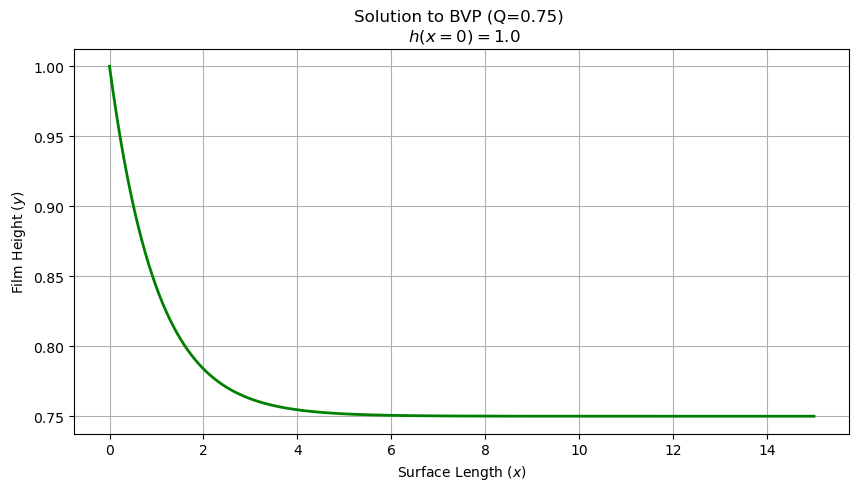

In [181]:
solution = steady_newt_solver(q=GV['Q'], L=15, linear=True)
plot_solution(solution, GV['Q'])

In [182]:
linear_solution_Q = []      # Store linear solutions varying Q
linear_solution_L = []      # Store linear solutions varying L
non_linear_solution_Q = []  # Store non-linear solutions varying Q
non_linear_solution_L = []  # Store non-linear solutions varying L

for i in range(3, len(GV['Q-list'])):
    linear_solution_Q.append(steady_newt_solver(q=GV['Q-list'][i], L=GV['L'], linear=True).y[0])
    non_linear_solution_Q.append(steady_newt_solver(q=GV['Q-list'][i], L=GV['L'], linear=False).y[0])
for i in range(len(GV['L-list'])):
    linear_solution_L.append(steady_newt_solver(q=GV['Q'], L=GV['L-list'][i], linear=True).y[0])
    non_linear_solution_L.append(steady_newt_solver(q=GV['Q'], L=GV['L-list'][i], linear=False).y[0])

Plot a fancy graph for the paper, I used the [inset_axes](https://python-graph-gallery.com/how-to-add-plot-inside-plot/) feature to create the small part in the length graph to zoom in to confirm the lines are all there.

(0.8, 0.81)

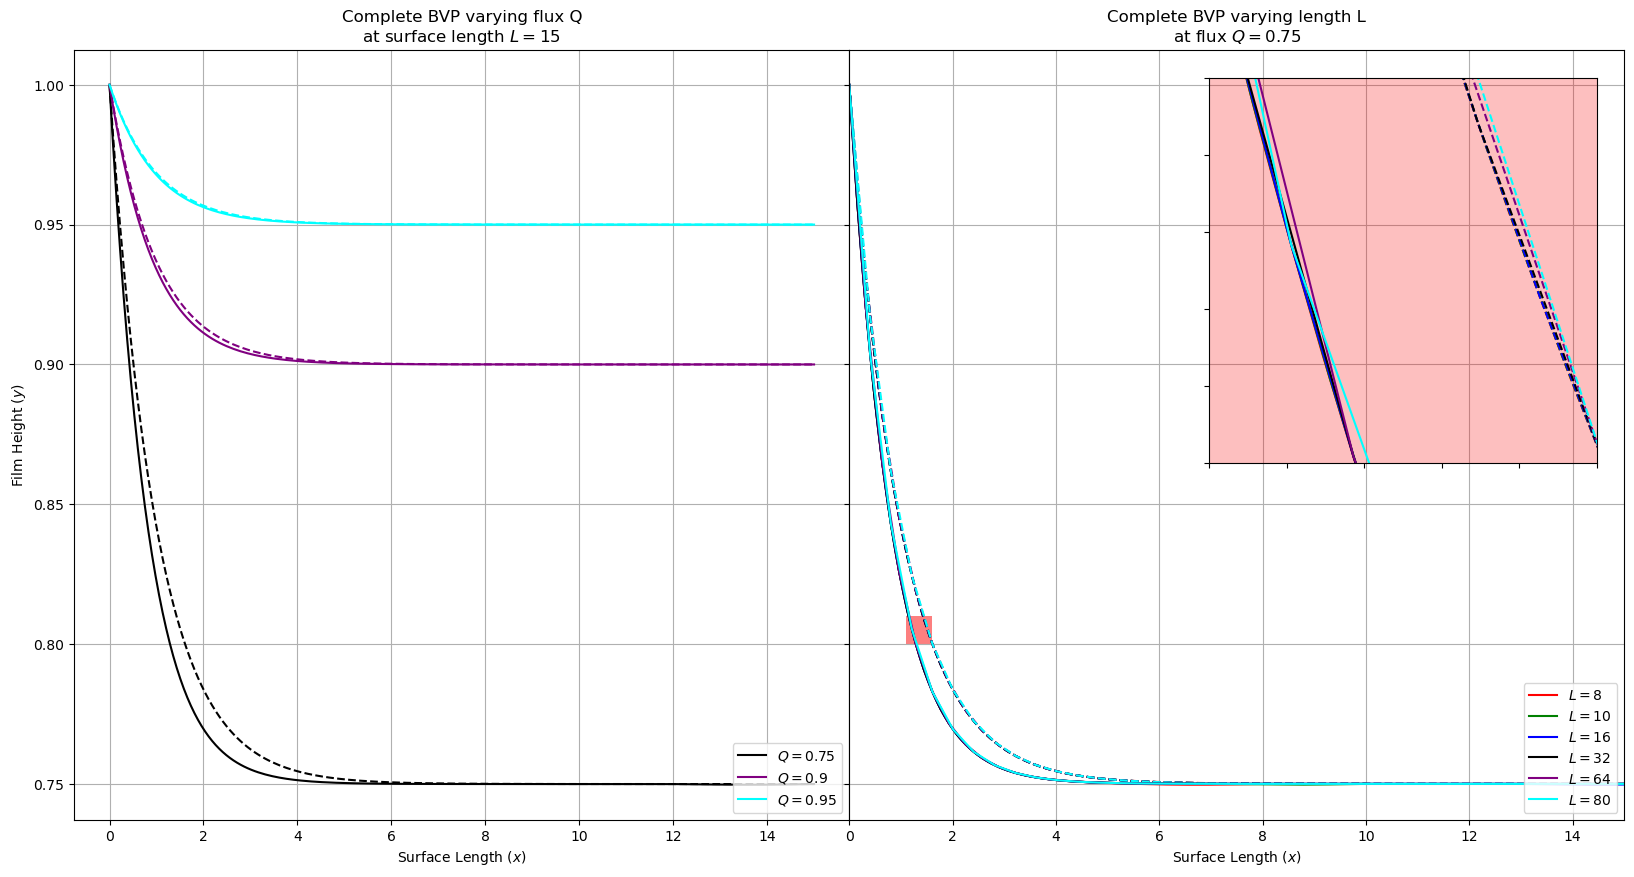

In [183]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.0)

[ax[0].plot(GV['x'], linear_solution_Q[i], color=GV['colors'][i+3], linestyle='--') for i in range(len(GV['Q-list'])-3)]
[ax[0].plot(GV['x'], non_linear_solution_Q[i], color=GV['colors'][i+3], label=f"$Q={GV['Q-list'][i+3]}$", linestyle='-') for i in range(len(GV['Q-list'])-3)]
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].set_title(f"Complete BVP varying flux Q\nat surface length $L={GV['L']}$")
ax[0].set_xlabel("Surface Length $(x)$")
ax[0].set_ylabel("Film Height $(y)$")

slice_x = (1.1, 1.6)
slice_y = (0.8, 0.81)

[ax[1].plot(np.linspace(0, GV['L-list'][i], GV['N']), linear_solution_L[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['L-list']))]
[ax[1].plot(np.linspace(0, GV['L-list'][i], GV['N']), non_linear_solution_L[i], color=GV['colors'][i], label=f"$L={GV['L-list'][i]}$", linestyle='-') for i in range(len(GV['L-list']))]
ax[1].legend(loc='lower right')
ax[1].set_xlim(0, GV['L'])
ax[1].grid(True)
ax[1].set_yticklabels([])
ax[1].set_title(f"Complete BVP varying length L\nat flux $Q={GV['Q']}$")
ax[1].set_xlabel("Surface Length $(x)$")
ax[1].add_patch(plt.Rectangle(xy=(slice_x[0], slice_y[0]), width=(slice_x[1]-slice_x[0]), height=(slice_y[1] - slice_y[0]), ls='--', fc='#fa000080'))

inset_ax = inset_axes(ax[1], width='50%', height='50%', loc='upper right', borderpad=2, axes_kwargs={'facecolor': '#fa000040'})
[inset_ax.plot(np.linspace(0, GV['L-list'][i], GV['N']), linear_solution_L[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['L-list']))]
[inset_ax.plot(np.linspace(0, GV['L-list'][i], GV['N']), non_linear_solution_L[i], color=GV['colors'][i], linestyle='-') for i in range(len(GV['L-list']))]
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xlim(slice_x[0], slice_x[1])
inset_ax.set_ylim(slice_y[0], slice_y[1])


## Monday 8th July - Startup-Flow Solve
The startup flow includes the time derivative, we see the film develop over time to hopefully produce the same thing as the steady state flow. We used the finite volume method to solve this PDE to ensure conservation of the mass of our 'quantities'

Here, for this application of the FVM method, as the boundary conditions are the same, the overhead equation for solving this PDE should be the same across models: $$\frac{\partial h}{\partial t} = -\frac{q_{i+\frac{1}{2}} - q_{i-\frac{1}{2}}}{\Delta x}$$and the only thing that is changing is the details inside the above equation, meaning we can define the RHS and apply the boundary conditions $$\begin{aligned} h[0] = h_0 \\ dhdt[1] = -\frac{q_{i+\frac{1}{2}} - Q}{dx} \\ dhdt[N-2] = -\frac{h[N-2] - q_{i-\frac{1}{2}}}{dx} \\ dhdt[N-1] = dhdt[N-2] \end{aligned} $$ in one equation that we can use for the rest of the investigation for startup flow across rheologies 

In [161]:
def FVM_RHS(t:float, h:np.ndarray, args:tuple) -> np.ndarray:
    """
    RHS of equation, made for scipy's solve_ivp function that takes care of this stiff fourth order PDE.
    """
    
    N = GV['N']
    
    make_step, dx, pwr, Q, n = args 
    
    h = h.copy()
    dhdt = np.zeros_like(h)

    # i = 0
    h[0] = GV['h0']

    # i = 1
    q_plus, q_minus = make_step(h=h, i=1, args=args)
    dhdt[1] = - (q_plus - Q) / dx

    # i = N - 2
    q_plus, q_minus = make_step(h=h, i=N-2, args=args)
    dhdt[N-2] = - (h[N-2] - q_minus) / dx

    # i = N - 1
    h[N-1] = h[N-2]
    dhdt[N-1] = dhdt[N-2]

    for i in range(2, N-2):
        q_plus, q_minus = make_step(h=h, i=i, args=args)
        dhdt[i] = -(q_plus - q_minus) / dx

    return dhdt

From here, the ```make_step``` function can be made according to the rheology of the fluid, in this case, our fluid is Newtonian.

In [171]:
def newt_make_step(h, i, args):
    """
    Try, excepts are for the BCs, as q_minus won't be computable for BCs at the start and q_plus won't be computable
    for BCs at the end.
    """
    
    _, dx, pwr, Q, n = args
    
    Dx = 1/dx**3
    try:
        non_linear_term =  ((h[i] + h[i+1])/2)**pwr
        q_plus = Dx * non_linear_term * (-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2]) + h[i]
    except IndexError: q_plus = 0

    try:
        non_linear_term =  ((h[i] + h[i-1])/2)**pwr
        q_minus = Dx * non_linear_term * (-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1]) + h[i-1]
    except IndexError: q_minus = 0

    return q_plus, q_minus

Time for a test run...

In [173]:
try:
    args = [newt_make_step, GV['dx'], 3, GV['Q'], None]
    h_initial = np.ones(GV['N']) * GV['h0']
    t_span = GV['t-span']
    
    sol = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8)

    print(sol.status)
    print(sol.success)
    print(sol.message)

except ValueError:
    print("Value Error")

0
True
The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Film Height $(y)$')

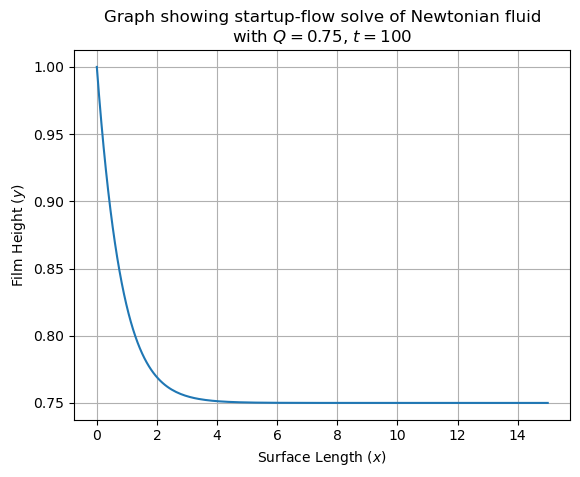

In [174]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={GV['t-span'][1]}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

In [136]:
linear_solution_Q = []      # Store linear solutions varying Q
non_linear_solution_Q = []  # Store non-linear solutions varying Q

for i in range(len(GV['Q-list'])):
    h_initial = np.ones(GV['N']) * GV['h0']
    t_span = GV['t-span']
    
    args = [GV['dx'], 0, GV['Q-list'][i], None]
    linear_solution_Q.append(solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])
    
    args = [GV['dx'], 3, GV['Q-list'][i], None]
    non_linear_solution_Q.append(solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])

Text(0, 0.5, 'Film Height $(y)$')

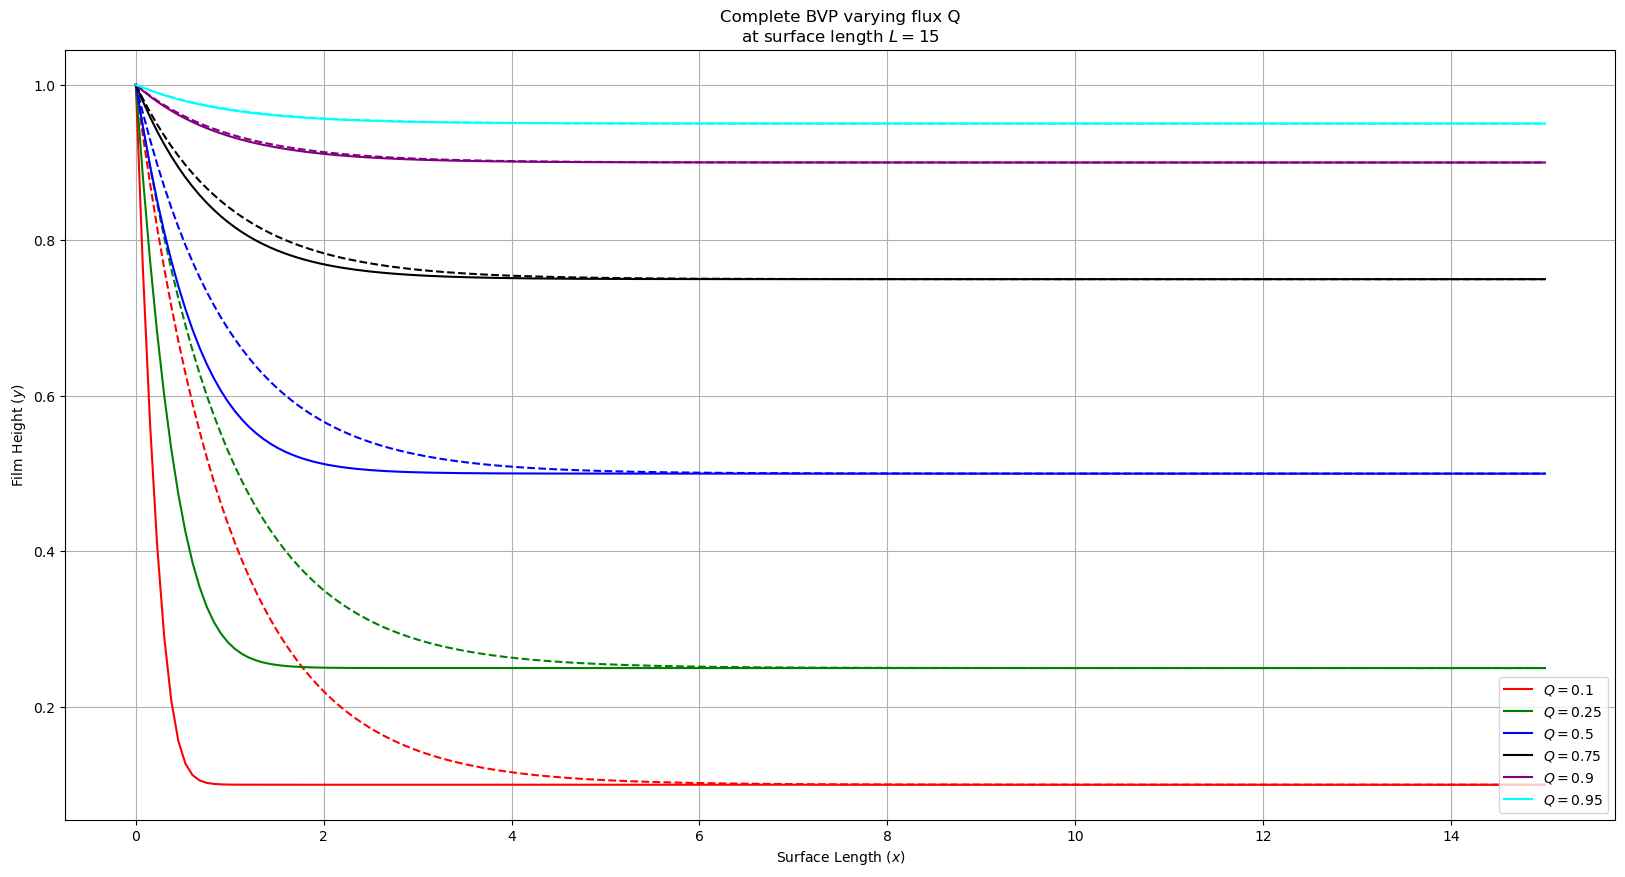

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.subplots_adjust(wspace=0.0)

[ax.plot(GV['x'], linear_solution_Q[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['Q-list']))]
[ax.plot(GV['x'], non_linear_solution_Q[i], color=GV['colors'][i], label=f"$Q={GV['Q-list'][i]}$", linestyle='-') for i in range(len(GV['Q-list']))]
ax.legend(loc='lower right')
ax.grid(True)
ax.set_title(f"Complete BVP varying flux Q\nat surface length $L={GV['L']}$")
ax.set_xlabel("Surface Length $(x)$")
ax.set_ylabel("Film Height $(y)$")

## Wednesday 16th July - Power Law Fluid

The numerics of non-Newtonian flow are very similar for the power law as Newtonian flow, it's the maths that's that's the hard part, which is explained in my thesis, linked in the READ_ME of this repo. The short version is that we replace the stress tensor $\tau$ with the power law: $\tau = \hat{\mu}|\dot{\gamma}|^{\frac{1}{n}}\dot{\gamma}$ and inject this into the equation for the pressure, take the derivative and go from there. 

We use the same finite volume method, only altering the function outlining the content of the RHS which now contains a lot of n's. We solve the equation 
$$
h_t = -\frac{\partial}{\partial x}\left(h^{\frac{2n+1}{n}}sgn(h_{xxx})\left|h_{xxx}\right|^{\frac{1}{n}}\right) + h_x
$$ 

We test this equation by setting n to 1 which we can do both analytically and numerically. The latter will be done in this jupyter notebook. <br> As stated, the only function that is altered for non-Newtonian startup flow is the function for making the step in space, so let's write it...

In [176]:
def PL_make_step(h, i, args):
    """
    (Try, except)'s are for the BCs, as q_minus won't be computable for BCs at the start and q_plus won't be computable
    for BCs at the end.
    The bool 'print_except' is for making sure anything inside the for loop is not displaying a 0.
    """
    
    _, dx, pwr, Q, n = args

    DX = 1/dx**3
    epsilon = 0

    try:
        non_linear_h = (0.5 * (h[i] + h[i+1]))**((2*n + 1)/n) + epsilon
        third_order = abs(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2] + epsilon) ** (1 / n)
        third_order_sign = np.sign(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2])
        advection_term = h[i]

        q_plus = DX  * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_plus = 0

    try:
        non_linear_h = (0.5 * (h[i] + h[i-1])) ** ((2*n+1)/n) + epsilon
        third_order = abs(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1] + epsilon) ** (1 / n)
        third_order_sign = np.sign(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1])
        advection_term = h[i-1]

        q_minus = DX * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_minus = 0

    return q_plus, q_minus

In [177]:
n = 0.9
h_initial = np.ones(GV['N']) * GV['h0']
t_span = GV['t-span']
args = [PL_make_step, GV['dx'], None, GV['Q'], n]

sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)

print(sol.status)
print(sol.success)
print(sol.message)

0
True
The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Film Height $(y)$')

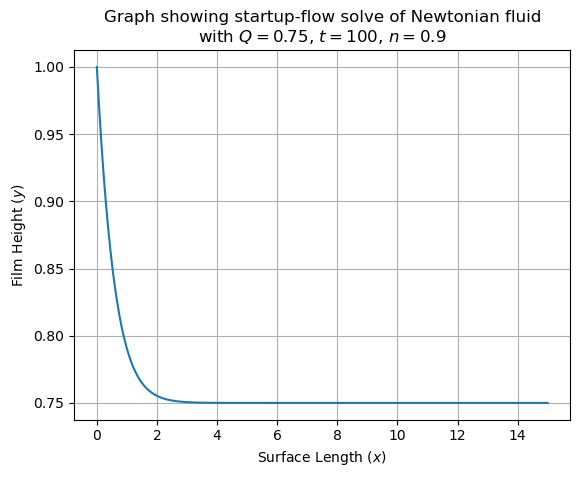

In [178]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={GV['t-span'][1]}$, $n={n}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

## ERROR GRAPHS
To ensure the model's validity, each model will be compared with the steady state Newtonian flow and an error plot will be made.

In [189]:
# Newtonian steady state solve
steady_state_newt = steady_newt_solver(q=GV['Q'], L=15, linear=False).y[0]

# Newtonian startup flow solve
args = [newt_make_step, GV['dx'], 3, GV['Q'], None]
h_initial = np.ones(GV['N']) * GV['h0']
t_span = GV['t-span']
startup_flow_newt = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1]

# Power-law startup flow solve
args = [PL_make_step, GV['dx'], None, GV['Q'], 1]
startup_flow_PL = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1]

Text(0.5, 0, 'Surface Length $(x)$')

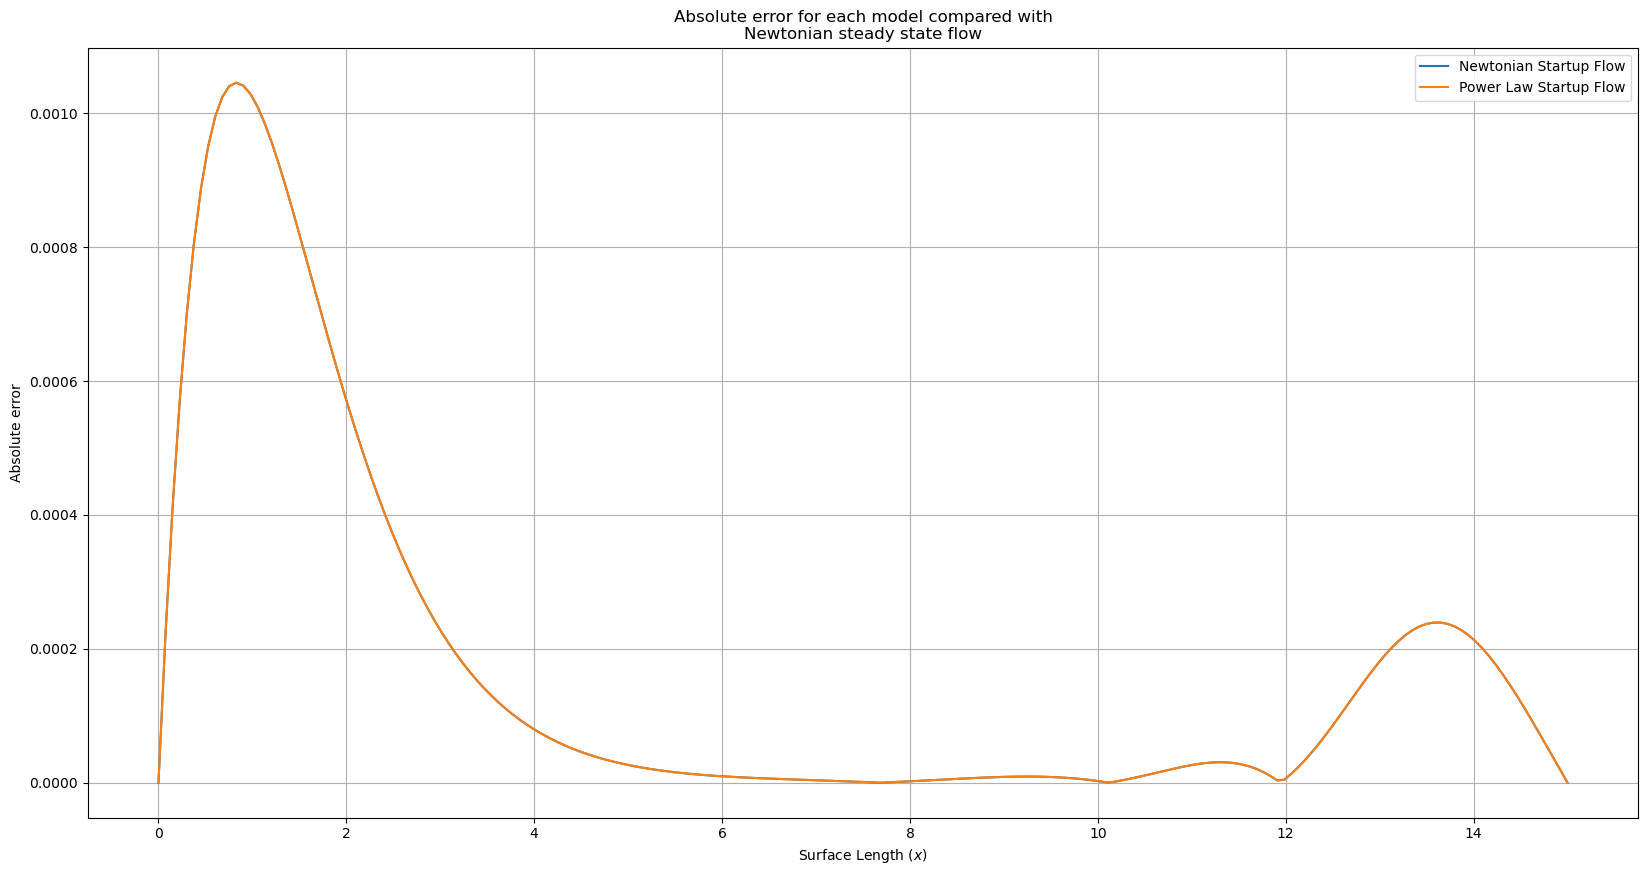

In [195]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

ax.plot(GV['x'], abs(steady_state_newt - startup_flow_newt), label="Newtonian Startup Flow")
ax.plot(GV['x'], abs(steady_state_newt - startup_flow_PL), label="Power Law Startup Flow")

ax.legend()
ax.grid(True)
ax.set_title("Absolute error for each model compared with\nNewtonian steady state flow")
ax.set_ylabel("Absolute error")
ax.set_xlabel("Surface Length $(x)$")